# ДЗ 1, часть 3. ЕМ-алгоритм

Имя, Фамилия: *напишите здесь*

группа: *напишите здесь группу, где вы числитесь*

**Оценка(для проверяющего):** 0 из 10

**Дедлайн:** 5 ноября 23:59 (решение нужно сдать в энитаск)

In [1]:
#all imports here please
import pickle as pkl
import tqdm
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
from random import choices
%matplotlib inline
#... add your own if necessary

## Задача 1. Поломки (5 баллов)

В офисе одного небольшого СобериБанка происходят поломки серверной. Служба обслуживания в таких случаях посылает специалиста решить проблему.  Для этого необходимо произвести обслуживание вычислительного узла А и вычислительного узла B. Каждый специалист имеет какую-то свою инструкцию, методологию, а также свой опыт, который определяет то, как именно он занимается ремонтном, и то, сколько времени у него занимают ремонтные работы.

В офисе точно могут сказать, сколько суммарно времени занял ремонт каждого из узлов(в минутах), обозначим их за переменные $X_A,~X_B$, но очень сложно понять, какие конкретно рабочие занимались ремонтом в каждом случае.

Коллеги вас, как экперта в статистике, просят оценить, сколько рабочих занято в ремонте вашей серверной. Немного посидев в браузере, вы узнаёте, что, оказывается, времена обслуживания техники можно моделировать с помощью знакомого [логнормального распределения](https://en.wikipedia.org/wiki/Log-normal_distribution). 

Используя ЕМ-алгоритм, модель смеси распределений, а также приложенный датасет, определите сколько рабочих могло участвовать в ремонте серверной за время наблюдений. Можете ли вы определить, какой рабочий участвовал в каждом ремонте?

Действуем по инструкции.

### Посмотрим на датасет

Откройте приложенный датасет и нарисуйте диаграмму разброса (scatterplot) в осях $X_A,~X_B$, чтобы посмотреть, что в целом дано. Возможно, удобнее перейти в логарифмические оси.

In [33]:
with open("./maintenance.pkl","rb") as f:
    dd = pkl.load(f)

In [34]:
X_A = []
X_B = []

for elem in dd['times(min)']:
    X_A.append(elem[0])
    X_B.append(elem[1])
    
X_A = np.array(X_A)
X_B = np.array(X_B)

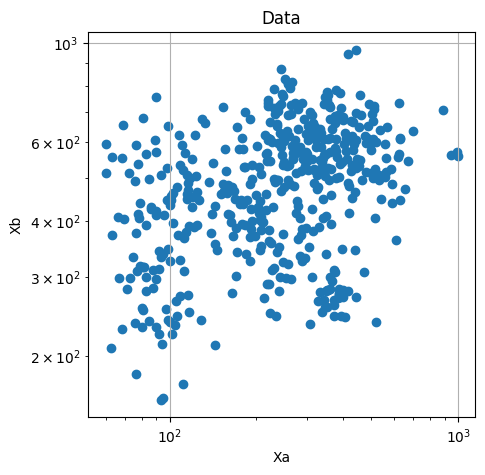

In [35]:
f,ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Data")
plt.scatter(X_A, X_B)
ax.set_xlabel("Xa")
ax.set_ylabel("Xb")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [36]:
#more plots?

### Модель

Опишите модель смеси, которая вам пригодится для решения задачи. Число компонент будем определять экспериментально, а остальное надо оценивать. Предполагается, что вектор $[\ln X_A, \ln X_B]$ у каждого рабочего имеет нормальное распределение. Логарифмы $\ln X_A$ и $\ln X_B$ могут быть коррелированы, но пары  $(X^i_A,X^i_B)$ независимы в совокупности.

* Что по смыслу задачи является скрытыми переменными $Y_i$ (номерами компонент)?
* Какое вы можете предложить распределение для пары $(X^i_A, X^i_B)$? Будьте здесь внимательны!
* Какие параметры $\theta$ есть в вероятностной модели?

$Y_i$ - номера рабочих\
$(X^i_A, X^i_B) \sim L\mathcal{N}(\mu_i, \Sigma_i)$\
В вероятностной модели есть параметры $\Pi_i, \mu_i, \Sigma_i, i \in \{Y_1, \dots, Y_K\}$

### Матчасть

Построим математическую основу решения задачи. Выведите и запишите формулы для ЕМ-алгоритма: Е-шаг (вычисление необходимых весов наблюдений) и М-шаг (обновление параметров).

В решении я ипользую denominator layout, т. е. считаю, что результат дифференцирования скаляра по вектору - это вектор-столбец.


![task1_1](task1_1.jpeg)

![task1_2](task1_2.jpeg)

![task1_3](task1_3.jpeg)

![task1_4](task1_4.jpeg)

### Имплементация модели

Будем использовать уже знакомый пайплайн для смеси распределений, который вы видели в семинарах, как основу. Вам предлагается заполнить детали и дописать вычисление Q-функции и лог-правдоподобия для логирования. Предлагаемые тесты смотрите ниже.

* Напишите код модели: начните с заполнения ``init`` и ``sample``, протестируйте, что всё семплится, как вы ожидаете (см. первый тест ниже).
* Добавьте ``fit`` и протестируйте его, он должен корректно оценивать параметры по выборке (см. второй тест ниже)
* Нарисуйте в каждом тесте график зависимости логправдоподобия (по наблюдаемым переменным) и Q-функции от номера итерации, чтобы убедиться, что алгоритм к чему-то сходится.

Поскольку в математической части все векторы считаются столбцами, а при программном решении - строками, я буду использовать оценку для транспонированных средних (в коде - просто средних, поскольку в коде средние - это строки), а также скорректирую оценку на матрицы ковариаций с учетом этого факта.

In [48]:
class LogNMixtureModel:
    '''
    Implements LogN Mixture Model in R^d
    '''

    def __init__(self,K=1,mus=[0],sigmas=[1], pis=[1]):
        """
        Args:
            K (int, optional): number of components. Defaults to 1.
            mus (list, optional): K entries of (d,), expected values. Defaults to [0].
            sigmas (list, optional): K entries of (d,d,), covariances. Defaults to [1].
            pis (list, optional): K floats, weights, positive and sump up to 1. Defaults to [1].
        """        
        self.K=K
        self.mus = mus
        self.sigmas = sigmas
        self.pis = pis

    def __str__(self):
        """Prints the parameters

        Returns:
            out (str): text print as if you would write print(myModel)
        """ 
        s = f'Number of components: {self.K}\n'
        s += f'Mus: {self.mus}\n'
        s += f'Sigmas: {self.sigmas}\n'
        s += f'Pis: {self.pis}\n'
        return s

    def sample(self, N=10):
        """Samples N samples from the model

        Args:
            N (int, optional): number of samples. Defaults to 10.

        Returns:
           result(float[]) : N d-dimensional samples (N,d)
           ids(int[]) : mixture ids (N,)
        """        
        ids = np.array(choices(np.arange(self.K), self.pis, k=N))
        samples_norm = np.array([spstats.multivariate_normal.rvs(self.mus[idx],
                                                                 self.sigmas[idx]) for idx in ids])
        result = np.exp(samples_norm)

        return result, ids

    def EStep(self, data):
        """Performs E-Step (computation of theta0 weights)

        Args:
            data (float[]): Training data (N,d)
        """
        self.gammas = []
        for k in range(self.K):
            for i in range(len(data)):
                numerator = (spstats.multivariate_normal.pdf(np.log(data[i]),
                                                             mean=self.mus[k], cov=self.sigmas[k])
                             * self.pis[k]
                            )
                denominator = 0
                for s in range(self.K):
                    denominator += (spstats
                                    .multivariate_normal
                                    .pdf(np.log(data[i]), mean=self.mus[s], cov=self.sigmas[s])
                                    * self.pis[s])
                self.gammas.append(numerator / denominator)
        self.gammas = np.array(self.gammas).reshape(self.K, len(data))
    
    def MStep(self, data):
        """Performs M-Step (weight update)

        Args:
            data (float[]): Training data (N,d)
        """
        
        Gammas = []
        for k in range(self.K): 
            Gammas.append(np.sum(self.gammas[k, :]))
        Gammas = np.array(Gammas)
        self.pis = []
        for i in range(self.K):
            if i == self.K - 1:
                self.pis.append(1 - np.sum(self.pis))
                break
            self.pis.append(Gammas[i] / np.sum(Gammas))
        self.pis = np.array(self.pis)
        
        self.mus = []
        for k in range(self.K):
            coef = 1 / np.sum(self.gammas[k, :])
            ln_x_i_sum = np.array([0., 0.])
            for i in range(data.shape[0]):
                ln_x_i_sum += self.gammas[k][i] * np.log(data[i])
            self.mus.append(coef * ln_x_i_sum)
        self.mus = np.array(self.mus)
                
        self.sigmas = []
        for k in range(self.K):
            coef = 1 / np.sum(self.gammas[k, :])
            tmp_sum = np.zeros(sigmas[0].shape, dtype=float)
            for i in range(data.shape[0]):
                tmp_sum += (self.gammas[k][i] *
                            (np.log(data[i]) - self.mus[k]).reshape(data[i].shape[0], 1) @
                            np.expand_dims(np.log(data[i]) - self.mus[k], 0)
                           )
            self.sigmas.append(coef * tmp_sum)
        self.sigmas = np.array(self.sigmas)
        
    def fit(self, data, nSteps):
        """Fits the model

        Args:
            data (float[]): (batch, d), given data
            nSteps (int): number of steps for EM
        """        
        #YOUR CODE
        #EM Loop
        self._Qfun_vals = []
        self._loglike_vals = []
        
        for _ in tqdm.tqdm(np.arange(nSteps)):
            self.EStep(data)
            self.MStep(data)
            self._Qfun_vals.append(self._Qfun(data))
            self._loglike_vals.append(self._loglike(data))
            
    def _Qfun(self,data):
        """Computes Q-function

        Args:
            data (float[]): (N,2)
        Returns:
            qfun (float): Qfunction value
        """
        qfun = 0
        for i in range(data.shape[0]):
            for k in range(self.K):
                qfun += self.gammas[k, i] * (np.log(self.pis[k] *
                                                    spstats.multivariate_normal.pdf(np.log(data[i]),
                                                                                    mean=self.mus[k],
                                                                                    cov=self.sigmas[k])
                                                   )
                                            )
        
        return qfun
                
                
    def _loglike(self,data):
        """Computes observable log-likelihood

        Args:
            data (float[]): (N,2)
        Returns:
            loglike (float): log-likelihood value
        """
        L = 0
        for k in range(self.K):
            L += self.pis[k] * np.sum(spstats.multivariate_normal.pdf(np.log(data), mean=self.mus[k],
                                                                       cov=self.sigmas[k]) /
                                       np.prod(data, axis=1)
                                     )
        
        return np.log(L)

In [39]:
#Test1: init model and sample from it, draw scatter plot

mus = [np.array([2,2]), np.array([4,4])]
sigmas = [0.2*np.eye(2), 0.05*np.eye(2)]
pis=[0.3,0.7]
mixMod = LogNMixtureModel(2,mus,sigmas,pis)

xs, ids = mixMod.sample(100)

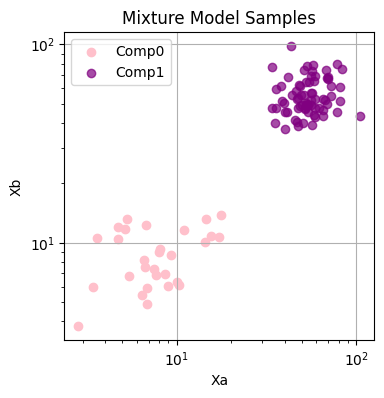

In [40]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
samples_0 = xs[ids == 0]
X_A_0 = []
X_B_0 = []
for elem in samples_0:
    X_A_0.append(elem[0])
    X_B_0.append(elem[1])
    
X_A_1 = []
X_B_1 = []
samples_1 = xs[ids == 1]
for elem in samples_1:
    X_A_1.append(elem[0])
    X_B_1.append(elem[1])
ax.scatter(X_A_0, X_B_0, color='pink')
ax.scatter(X_A_1, X_B_1, color='purple', alpha=0.7)
ax.legend(["Comp0","Comp1"])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Xa")
ax.set_ylabel("Xb")
plt.show()

In [41]:
#Test2: init model sample from it, draw scatter plot, estimate parameters, check that the estimate is correct.
mus = [np.array([2,2]), np.array([4,4])]
sigmas = [0.2*np.eye(2), 0.05*np.eye(2)]
pis=[0.3,0.7]
mixMod = LogNMixtureModel(2,mus,sigmas,pis)

xs, ids = mixMod.sample(1000)

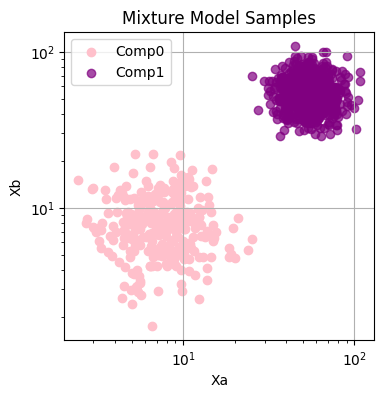

In [42]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
ax.set_xlabel("Fixing time")
samples_0 = xs[ids == 0]
X_A_0 = []
X_B_0 = []
for elem in samples_0:
    X_A_0.append(elem[0])
    X_B_0.append(elem[1])
    
X_A_1 = []
X_B_1 = []
samples_1 = xs[ids == 1]
for elem in samples_1:
    X_A_1.append(elem[0])
    X_B_1.append(elem[1])
ax.scatter(X_A_0, X_B_0, color='pink')
ax.scatter(X_A_1, X_B_1, color='purple', alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Xa")
ax.set_ylabel("Xb")
ax.legend(["Comp0","Comp1"])
plt.show()

In [49]:
mus = [np.zeros([2]), np.zeros([2])]
sigmas = [np.eye(2), np.eye(2)]
pis=[0.9,0.1]
mixMod1 = LogNMixtureModel(2,mus,sigmas,pis)

mixMod1.fit(xs,500)
print(mixMod1)

100%|█████████████████████████████████████████| 500/500 [02:41<00:00,  3.10it/s]

Number of components: 2
Mus: [[3.99001532 3.98903899]
 [1.99678442 2.02556739]]
Sigmas: [[[ 0.05087302 -0.00223926]
  [-0.00223926  0.05238377]]

 [[ 0.17512823 -0.0038227 ]
  [-0.0038227   0.19112499]]]
Pis: [0.69699978 0.30300022]



Параметры должны быть примерно как настоящие, это очень простой случай для EM.

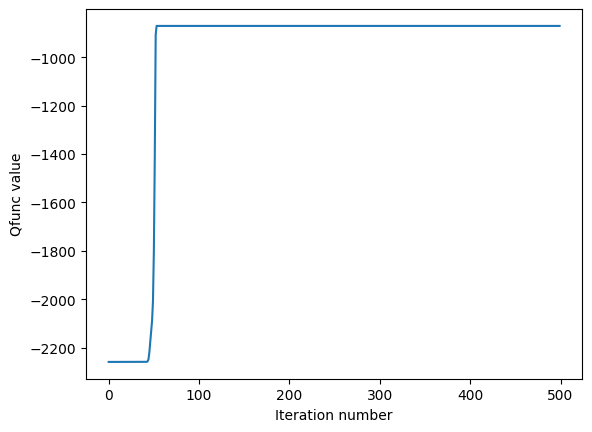

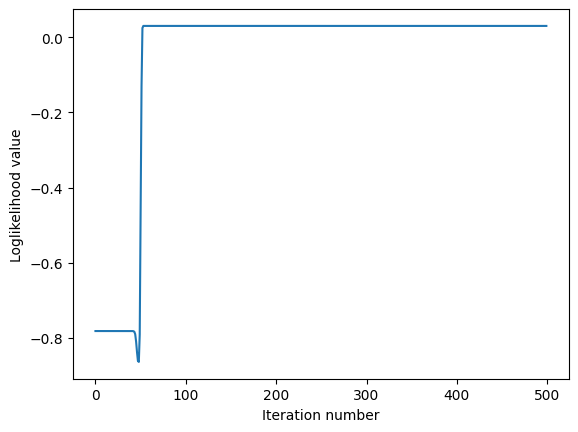

In [50]:
niters = np.arange(500)

plt.plot(niters, mixMod1._Qfun_vals)
plt.xlabel('Iteration number')
plt.ylabel('Qfunc value')
plt.show()

plt.plot(niters, mixMod1._loglike_vals)
plt.xlabel('Iteration number')
plt.ylabel('Loglikelihood value')
plt.show()

### Переходим к данным

Для оценки количества рабочих можно путём эксперимента подобрать количество кластеров. Попробуйте разное количество кластеров и подберите лучший. Ответьте на вопрос задачи и обоснуйте ваш выбор, используя написанный вами код.

In [51]:
dd

{'times(min)': array([[ 77.8113803 , 414.67749397],
        [ 76.76549944, 590.12737107],
        [ 93.68559825, 505.34739302],
        [942.50183327, 560.66347226],
        [440.90809208, 345.05562227],
        [182.19772096, 699.30984432],
        [100.64808114, 434.73288155],
        [626.71247996, 608.15207926],
        [297.4262149 , 569.49944044],
        [428.98449239, 533.67098904],
        [298.30993505, 564.23372841],
        [535.30948509, 638.28172045],
        [532.27810955, 494.80081333],
        [247.06903601, 616.50898438],
        [164.28081952, 275.64377092],
        [452.60211285, 647.93817546],
        [ 84.87553715, 239.20015909],
        [150.61770776, 458.72786417],
        [351.75922344, 777.81574764],
        [ 75.68780591, 236.88008741],
        [ 79.28098721, 438.89315835],
        [136.71603148, 489.60782835],
        [355.42053072, 764.78534794],
        [ 63.34217725, 555.04507989],
        [230.45104765, 497.5117938 ],
        [152.80749378, 483.84708414]

In [59]:
xs = dd['times(min)']

most_likely_nclusters = 0
max_loglike_val = -np.inf
for nclusters in range(1, xs.shape[0]):
    mus = [np.zeros([2]) for _ in range(nclusters)]
    sigmas = [np.eye(2) for _ in range(nclusters)]
    pis = np.repeat(0.1, nclusters).tolist()
    mixMod = LogNMixtureModel(nclusters, mus, sigmas, pis)
    mixMod.fit(xs,500)
    if mixMod._loglike_vals[-1] > max_loglike_val:
        most_likely_nclusters = nclusters
        max_loglike_val = mixMod._loglike_vals[-1]
    if mixMod._loglike_vals[-1] < max_loglike_val:
        break
        
print(f'Самое правдоподобное количество кластеров: {most_likely_nclusters}')

100%|█████████████████████████████████████████| 500/500 [03:53<00:00,  2.15it/s]

Самое правдоподобное количество кластеров: 3


По мере приближения количества кластеров к наилучшему (самому правдоподобному) количеству кластеров логправдоподобие монотонно растет, а по мере удаления от него - монотонно падает. Этим я и воспользовался при написании кода и поиске наилучшего количества кластеров.

## Задача 2. Тотальный контроль (5 баллов)

В чат по теории вероятности сообщения приходят круглосуточно и особенно часто -- в кризисное время, когда у всех проходят коллоквиумы и разные другие контрольные мероприятия. Если выгрузить сырой лог из чата, то можно посчитать длину сообщения в символах $X$ и момент времени $T$, когда сообщение пришло в чат. Предполагается, что $X$ и $T$ независимы, а также промежутки времени $\Delta T_i = T_{i+1} - T_i$ являются независимыми в совокупности.

Исследуя интернет, вы наткнулись на подходящее [экспоненциальное распределение](https://en.wikipedia.org/wiki/Exponential_distribution), которое используется в survival analysis, исследовании времён до происхождения следующего события, которое можно использовать для моделирования времени, и на уже известное [логнормальное распределение](https://en.wikipedia.org/wiki/Log-normal_distribution) для моделирования длины сообщений (несмотря на то, что длины целые, мы попробуем).

На основе наблюдений предложите вероятностную модель на основе смесей распределений, которая помогла бы вам научиться определять, является ли конкретный момент времени $t$, когда было прислано сообщение длины $x$, кризисным.

Как и раньше, действуем по инструкции.

### Посмотрим на датасет

Откройте приложенный датасет и нарисуйте гистограммы для $X_i$ и $\Delta T_i$ -- длин сообщений и времени, прошедшего с предыдущего сообщения.

In [2]:
with open("./terver.pkl","rb") as f:
    dd = pkl.load(f)
    

In [3]:
dd.keys()

dict_keys(['delta-times(min)', 'msgLen'])

In [4]:
X = dd['msgLen']
delta_T = dd['delta-times(min)']

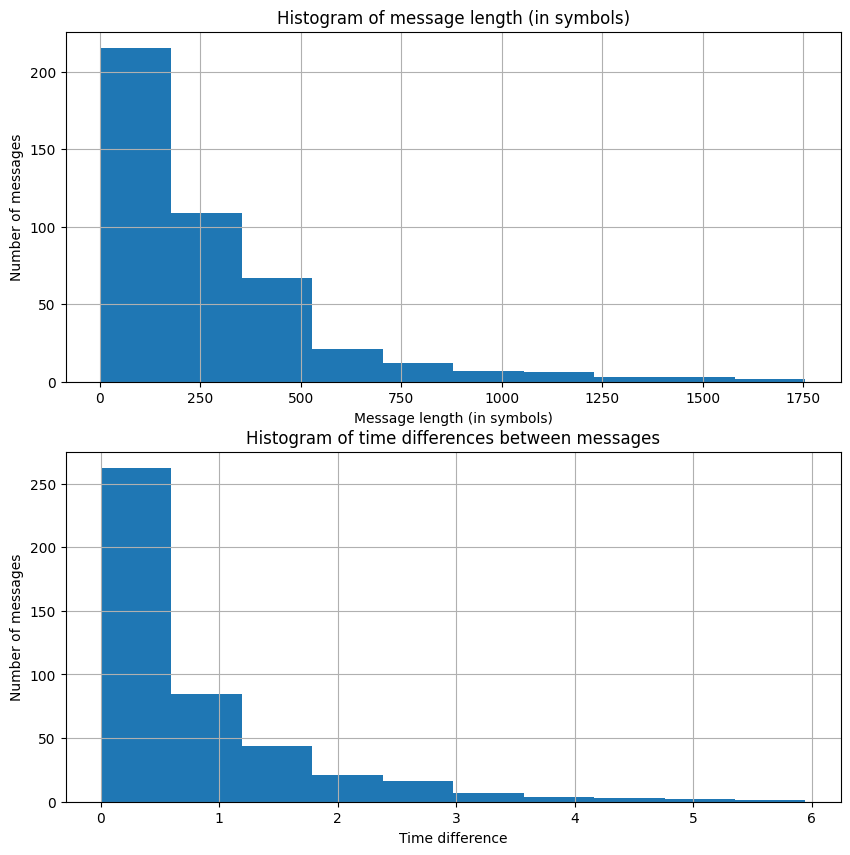

In [5]:
f,ax = plt.subplots(nrows=2, figsize=(10,10))

ax[0].grid()
ax[0].set_title("Histogram of message length (in symbols)")
ax[0].hist(X)
ax[0].set_xlabel("Message length (in symbols)")
ax[0].set_ylabel("Number of messages")

ax[1].grid()
ax[1].set_title("Histogram of time differences between messages")
ax[1].hist(delta_T)
ax[1].set_xlabel("Time difference")
ax[1].set_ylabel("Number of messages")

plt.show()

### Модель

Опишите модель смеси, которая вам пригодится для решения задачи. 

* Что по смыслу задачи является скрытыми переменными $Y_i$ (номерами компонент)?
* Какое вы можете предложить распределение для пары $(X^i, \Delta T_{i-1})$? Будьте здесь внимательны!
* Какие параметры $\theta$ есть в вероятностной модели?

$Y_i$ в данной задаче - это 0 и 1, где 0 соответствует тому, что сообщение было отправлено не в кризисное время, а 1 - тому, что в кризисное

$
(X^i, \Delta T_{i - 1}) \sim f_{mix}((X^i, \Delta T_{i - 1})) =
f_{L\mathcal{N}} (x_i) f_{Exp} (\Delta t_{i - 1})
$, т. к. $X$ и $T$ независимы

В модели есть параметры $\pi_i, \mu_i, \sigma_i, \lambda_i, i \in \{Y_1, \dots, Y_K\}$

### Матчасть

Построим математическую основу решения задачи. Выведите и запишите формулы для ЕМ-алгоритма: Е-шаг (вычисление необходимых весов наблюдений) и М-шаг (обновление параметров).

![task2_1](task2_1.jpeg)

![task2_2](task2_2.jpeg)

![task2_3](task2_3.jpeg)

![task2_4](task2_4.jpeg)

### Имплементация модели

Будем использовать уже знакомый пайплайн для смеси распределений, который вы видели в семинарах, как основу. Вам предлагается заполнить детали и дописать вычисление Q-функции и лог-правдоподобия для логирования. Предлагаемые тесты смотрите ниже.

* Напишите код модели: начните с заполнения ``init`` и ``sample``, протестируйте, что всё семплится, как вы ожидаете (см. первый тест ниже).
* Добавьте ``fit`` и протестируйте его, он должен корректно оценивать параметры по выборке (см. второй тест ниже)
* Нарисуйте в каждом тесте график зависимости логправдоподобия (по наблюдаемым переменным) и Q-функции от номера итерации, чтобы убедиться, что алгоритм к чему-то сходится.

In [66]:
class CustomMixtureModel:
    '''
    Implements Weibull Mixture Model in R^d
    '''

    def __init__(self,K,lambdas, pis, mus, sigmas):
        """
        Args:
            K (int, optional): number of components.
            mus (list, optional): K entries of (d,), expected values.
            sigmas (list, optional): K entries of (d,d,), covariances.
            pis (list, optional): K floats, weights, positive and sump up to 1.
        """        
        self.K=K
        self.pis = pis
        self.lambdas = lambdas
        self.mus = mus
        self.sigmas = sigmas

    def __str__(self):
        """Prints the parameters

        Returns:
            out (str): text print
        """ 
        return f"CustomMixture:\n pis={self.pis},\n mus={self.mus},\n sigmas={self.sigmas},\n lambdas={self.lambdas}"

    def sample(self, N=10):
        """Samples N samples from the model

        Args:
            N (int, optional): number of samples. Defaults to 10.

        Returns:
           result(float[]) : N d-dimensional samples (N,d)
           ids(int[]) : mixture ids (N,)
        """        
        ids = np.array(choices(np.arange(self.K), self.pis, k=N))
        result = np.array([[spstats.lognorm.rvs(self.sigmas[idx], scale=np.exp(self.mus[idx])),
                            spstats.expon.rvs(scale=1/self.lambdas[idx])] for idx in ids])

        return result, ids

    def EStep(self, data):
        """Performs E-Step (computation of theta0 weights)

        Args:
            data (float[]): Training data (N,d)
        """
        self.gammas = []
        for k in range(self.K):
            for i in range(len(data)):
                numerator = (spstats.lognorm.pdf(data[i][0], self.sigmas[k], scale=np.exp(self.mus[k])) *
                             spstats.expon.pdf(data[i][1], scale=1/self.lambdas[k]) *
                             self.pis[k]
                            )
                denominator = 0
                for s in range(self.K):
                    denominator += (spstats.lognorm.pdf(data[i][0], self.sigmas[s], scale=np.exp(self.mus[s])) *
                                    spstats.expon.pdf(data[i][1], scale=1/self.lambdas[s]) *
                                    self.pis[s]
                                   )
                self.gammas.append(numerator / denominator)
        self.gammas = np.array(self.gammas).reshape(self.K, len(data))
    
    def MStep(self, data):
        """Performs M-Step (weight update)

        Args:
            data (float[]): Training data (N,d)
        """
        data_arr = np.array(data).T
        
        Gammas = []
        for k in range(self.K): 
            Gammas.append(np.sum(self.gammas[k, :]))
        Gammas = np.array(Gammas)
        self.pis = []
        for i in range(self.K):
            if i == self.K - 1:
                self.pis.append(1 - np.sum(self.pis))
                break
            self.pis.append(Gammas[i] / np.sum(Gammas))
        self.pis = np.array(self.pis)
              
        self.mus = []
        for k in range(self.K):
            coef = 1 / np.sum(self.gammas[k, :])
            self.mus.append(coef * np.sum(self.gammas[k, :] * np.log(data_arr[0, :])))
        self.mus = np.array(self.mus)
                
        self.sigmas = []
        for k in range(self.K):
            coef = 1 / np.sum(self.gammas[k, :])
            self.sigmas.append(coef *
                               np.sum(self.gammas[k, :] *
                                      (np.log(data_arr[0, :]) - np.repeat(self.mus[k], data_arr.shape[1]))**2
                                     )
                              )
        self.sigmas = np.sqrt(np.array(self.sigmas))
        
        self.lambdas = []
        for k in range(self.K):
            coef = np.sum(self.gammas[k, :])
            self.lambdas.append(coef / np.sum(self.gammas[k, :] * data_arr[1, :]))
        self.lambdas = np.array(self.lambdas)
        
    def fit(self, data, nSteps):
        """Fits the model

        Args:
            data (float[]): (batch, d), given data
            nSteps (int): number of steps for EM
        """
        self._Qfun_vals = []
        self._loglike_vals = []
        
        for _ in tqdm.tqdm(np.arange(nSteps)):
            self.EStep(data)
            self.MStep(data)
            self._Qfun_vals.append(self._Qfun(data))
            self._loglike_vals.append(self._loglike(data))
            
    def _Qfun(self,data):
        """Computes Q-function

        Args:
            data (float[]): given data (N,2)
        Returns:
            qfun (float): Qfunction value
        """
        qfun = 0
        for i in range(data.shape[0]):
            for k in range(self.K):
                qfun += self.gammas[k, i] * (np.log(self.pis[k] *
                                                    spstats.lognorm.pdf(data[i][0],
                                                                        self.sigmas[k],
                                                                        scale=np.exp(self.mus[k])
                                                                       ) *
                                                    spstats.expon.pdf(data[i][1], scale=1/self.lambdas[k])
                                                   )
                                            )
        
        return qfun
                
    def _loglike(self,data):
        """Computes observable log-likelihood

        Args:
            data (float[]): given data (N,2)
        Returns:
            loglike (float): log-likelihood value
        """
        L = 0
        for k in range(self.K):
            L += self.pis[k] * np.prod(spstats.lognorm.pdf(data[:, 0],
                                                          self.sigmas[k],
                                                          scale=np.exp(self.mus[k])
                                                         ) *
                                      spstats.expon.pdf(data[:, 1], scale=1/self.lambdas[k])
                                     )
        
        return np.log(L)


In [55]:
#Test1: init model and sample from it, draw scatter plot
mus = np.array([0., 0.3])
sigmas = np.array([0.9, 2.1])
pis= np.array([0.8,0.2])
lambdas = np.array([1.1, 2.1])
mixMod = CustomMixtureModel(2, lambdas, pis, mus, sigmas)

xs, ids = mixMod.sample(1000)

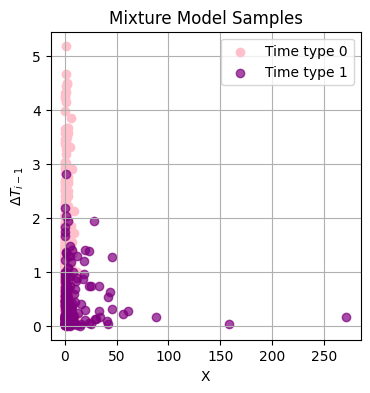

In [56]:
f,ax = plt.subplots(figsize=(4,4))

ax.grid()
ax.set_title("Mixture Model Samples")
samples_0 = xs[ids == 0]
X_0 = []
delta_T_0 = []
for elem in samples_0:
    X_0.append(elem[0])
    delta_T_0.append(elem[1])
    
X_1 = []
delta_T_1 = []
samples_1 = xs[ids == 1]
for elem in samples_1:
    X_1.append(elem[0])
    delta_T_1.append(elem[1])
ax.scatter(X_0, delta_T_0, color='pink')
ax.scatter(X_1, delta_T_1, color='purple', alpha=0.7)
ax.legend(["Time type 0","Time type 1"])
ax.set_xlabel("X")
ax.set_ylabel("$\Delta T_{i - 1}$")
plt.show()

In [57]:
#Test2: init model sample from it, draw scatter plot, estimate parameters, check that the estimate is correct.
mus = np.array([0.1, 0.2])
sigmas = np.array([1., 2.])
pis= np.array([0.3, 0.7])
lambdas = np.array([1., 2.])
mixMod = CustomMixtureModel(2, lambdas, pis, mus, sigmas)

mixMod.fit(xs, 1000)
print(mixMod)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/var/folders/d4/h9z5_gyn0sv37y7k4s5pcwpr0000gn/T/ipykernel_3380/632935765.py:163: RuntimeWarning: divide by zero encountered in log
  return np.log(L)
100%|███████████████████████████████████████| 1000/1000 [11:47<00:00,  1.41it/s]

CustomMixture:
 pis=[0.75410133 0.24589867],
 mus=[0.01429715 0.37739235],
 sigmas=[0.83471901 1.94547053],
 lambdas=[1.0982533  1.99728073]


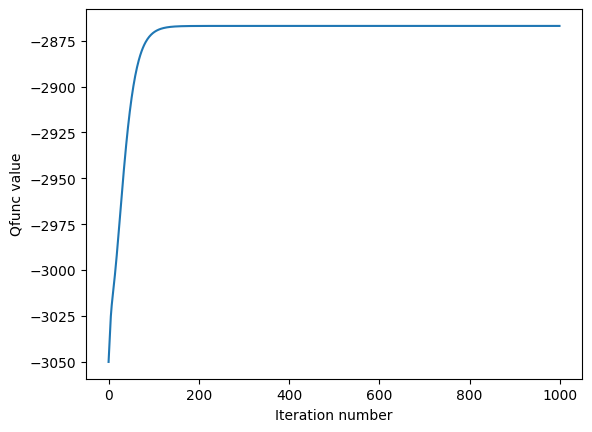

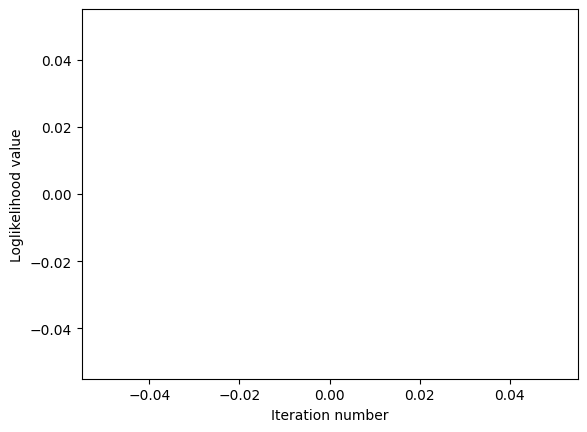

In [58]:
niters = np.arange(1000)

plt.plot(niters, mixMod._Qfun_vals)
plt.xlabel('Iteration number')
plt.ylabel('Qfunc value')
plt.show()

plt.plot(niters, mixMod._loglike_vals)
plt.xlabel('Iteration number')
plt.ylabel('Loglikelihood value')
plt.show()

### Ответы

Какие сообщения были написаны в кризисное время, а какие в нормальное?

Какая доля сообщений была написана в кризисное время?

Обоснуйте свои ответы, используя ваш код.

In [67]:
dd

{'delta-times(min)': array([2.24916014e+00, 3.90576744e+00, 2.49736389e-01, 3.13399216e+00,
        5.13072786e-01, 2.77893270e-01, 1.01707116e+00, 5.26985462e-01,
        7.82063864e-01, 2.74405714e-01, 1.20972282e+00, 2.11516628e-02,
        1.27949125e+00, 5.03536222e-01, 1.55603134e-01, 2.78850654e+00,
        4.28745949e-01, 3.11143835e-01, 3.09181320e+00, 8.38707234e-02,
        4.50859964e-01, 2.38147632e-01, 7.11422901e-01, 1.04407867e+00,
        3.87167706e-01, 4.14307727e-01, 4.42262652e-01, 1.80586935e+00,
        8.27252583e-01, 2.41426063e-01, 7.78691459e-01, 1.77251170e+00,
        1.89797275e-01, 1.12222179e-01, 2.82073432e+00, 5.60265525e-01,
        3.19994840e-01, 1.37812711e-01, 2.34058721e+00, 5.05244773e-01,
        2.39517095e-01, 1.75628632e-01, 3.13868499e-01, 2.79546272e-01,
        1.62901674e+00, 6.37802908e-01, 8.74056466e-01, 2.49293381e+00,
        1.40919451e-01, 2.95905348e+00, 2.62505094e+00, 8.90241193e-01,
        1.03323564e+00, 2.16824283e-01, 1.55

In [68]:
data = np.concatenate((dd['msgLen'].reshape(-1, 1), dd['delta-times(min)'].reshape(-1, 1)), axis=1)

In [69]:
mus = np.array([0.1, 0.2])
sigmas = np.array([1., 2.])
pis= np.array([0.5, 0.5])
lambdas = np.array([1., 2.])
mixMod = CustomMixtureModel(2, lambdas, pis, mus, sigmas)

mixMod.fit(data, 1000)

100%|███████████████████████████████████████| 1000/1000 [05:18<00:00,  3.14it/s]


In [79]:
K = 2
time_0_messages = []
time_1_messages = []

for i in range(data.shape[0]):
    prob_clust_0 = (spstats.lognorm.pdf(data[i, 0], mixMod.sigmas[0], scale=np.exp(mixMod.mus[0])) *
                    spstats.expon.pdf(data[i, 1], scale=1/mixMod.lambdas[0]))
    prob_clust_1 = (spstats.lognorm.pdf(data[i, 0], mixMod.sigmas[1], scale=np.exp(mixMod.mus[1])) *
                    spstats.expon.pdf(data[i, 1], scale=1/mixMod.lambdas[1]))
    if prob_clust_0 > prob_clust_1:
        time_0_messages.append(i)
    else:
        time_1_messages.append(i)

if np.mean(data[time_0_messages, 1]) < np.mean(data[time_1_messages, 1]):
    print(f'Dataset indices of messages sent in crysis time:{time_0_messages}')
    print(f'Share of messages sent in crysis time: {len(time_0_messages) / data.shape[0]}')
else:
    print(f'Dataset indices of messages sent in crysis time:{time_1_messages}')
    print(f'Share of messages sent in crysis time: {len(time_1_messages) / data.shape[0]}')
            

Dataset indices of messages sent in crysis time:[4, 11, 13, 16, 19, 20, 21, 26, 30, 33, 36, 37, 39, 40, 42, 43, 46, 48, 53, 55, 56, 58, 59, 60, 61, 63, 64, 67, 68, 70, 75, 78, 79, 81, 83, 86, 87, 88, 90, 92, 93, 94, 97, 98, 101, 108, 109, 111, 113, 115, 116, 118, 119, 122, 123, 125, 128, 130, 133, 135, 138, 146, 150, 154, 155, 156, 161, 163, 170, 171, 174, 175, 177, 183, 189, 193, 196, 197, 198, 199, 202, 203, 212, 214, 219, 220, 221, 224, 229, 231, 234, 235, 239, 241, 244, 248, 251, 255, 260, 264, 267, 270, 278, 283, 284, 290, 293, 295, 296, 298, 300, 302, 304, 305, 306, 311, 315, 323, 324, 328, 334, 336, 340, 341, 342, 344, 346, 349, 352, 353, 357, 362, 366, 369, 370, 373, 375, 376, 378, 379, 380, 381, 382, 383, 385, 386, 391, 393, 397, 399, 400, 405, 411, 414, 419, 421, 422, 426, 427, 431, 433, 435, 437, 441, 443, 444]
Share of messages sent in crysis time: 0.37303370786516854
